In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

In [48]:
data = pd.read_csv("data/train.csv")

In [49]:
training = data[~data['MISSING_DATA']]

# adding date time, modified from given feature engineering notebook
getdate = lambda x : [tuple([i.year, i.month, i.day, i.hour, i.weekday()]) for i in [datetime.fromtimestamp(x["TIMESTAMP"])]][0]
training[["YR", "MON", "DAY", "HR", "WK"]] = training[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
training = training.drop(columns = ['TIMESTAMP'])

# adding trip time, using the given 15 second formula on polyline
training['TRIP_TIME'] = training['POLYLINE'].apply(lambda x : max(x.count(".")/2-1,0)*15)
training = training.drop(columns = ['POLYLINE'])

C:\Users\ishpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [184]:
truetest = pd.read_csv("data/test_public.csv")
truetest[["YR", "MON", "DAY", "HR", "WK"]] = truetest[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
truetest = truetest.drop(columns = ['TIMESTAMP'])

In [185]:
truetest

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK
0,T1,B,NaN,15.0,20000542,A,False,2014,8,14,10,3
1,T2,B,NaN,57.0,20000108,A,False,2014,8,14,10,3
2,T3,B,NaN,15.0,20000370,A,False,2014,8,14,10,3
3,T4,B,NaN,53.0,20000492,A,False,2014,8,14,10,3
4,T5,B,NaN,18.0,20000621,A,False,2014,8,14,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,A,False,2014,12,21,6,6
316,T324,B,NaN,53.0,20000020,A,False,2014,12,21,6,6
317,T325,C,NaN,NaN,20000207,A,False,2014,12,21,6,6
318,T326,A,76232.0,NaN,20000667,A,False,2014,12,21,6,6


In [50]:
og = training
training.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,1372636858620000589,C,NaN,NaN,20000589,A,False,2013,6,30,17,6,330.0
1,1372637303620000596,B,NaN,7.0,20000596,A,False,2013,6,30,17,6,270.0
2,1372636951620000320,C,NaN,NaN,20000320,A,False,2013,6,30,17,6,960.0
3,1372636854620000520,C,NaN,NaN,20000520,A,False,2013,6,30,17,6,630.0
4,1372637091620000337,C,NaN,NaN,20000337,A,False,2013,6,30,17,6,420.0


In [217]:
training = og#[og['TRIP_TIME']]

In [237]:
days = [(8,14),(9,30),(10,6),(10,31),(12,21)]

narrows = [training[(training['MON'] == i[0])&(training['DAY']==i[1])].drop(columns = ['MON','DAY']).assign(date=j) for j,i in enumerate(days)]
tnarrows = [truetest[(truetest['MON'] == i[0])&(testing['DAY']==i[1])].drop(columns = ['MON','DAY']).assign(date=j) for j,i in enumerate(days)]

narrowed = pd.concat(narrows)
tnarrowed = pd.concat(tnarrows)

In [236]:
def knntrans(data, test=pd.DataFrame(), w = [3,0,0,1,0]):
    data = pd.concat([data,test])
    data = data.drop(columns = ['TRIP_ID','DAY_TYPE','MISSING_DATA','YR'])
    
    ones = pd.get_dummies(data['CALL_TYPE'])*w[0]
    ones = ones.join(pd.get_dummies(data['ORIGIN_STAND'])*w[1])
    ones = ones.join(pd.get_dummies(data['TAXI_ID'])*w[2])
        
#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['DAY'])*w[4])).rename(columns = {i:f'd{i}' for i in range(31)})))
#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['WK'])*w[3])).rename(columns = {0:'d0',1:'d1',2:'d2',3:'d3',4:'d4',5:'d5',6:'d6'})))

#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['MON'])*w[4])).rename(columns = {i:f'm{i}' for i in range(12)})))
#    ones['MON'] = np.abs(data['MON']-6)/6*w[4]

    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['HR'])*w[3])).rename(columns = {i:f'h{i}' for i in range(24)})))
#    ones['HR'] = np.abs(data['HR']-12)/12*w[5]

    ones = ones.join((pd.get_dummies(data['date'])*w[4]).rename(columns = {i:f'date{i}' for i in range(5)}))
    return ones.iloc[:-test.shape[0],:],ones.iloc[-test.shape[0]:,:]#.to_numpy()

In [220]:
training

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,1372636858620000589,C,NaN,NaN,20000589,A,False,2013,6,30,17,6,330.0
1,1372637303620000596,B,NaN,7.0,20000596,A,False,2013,6,30,17,6,270.0
2,1372636951620000320,C,NaN,NaN,20000320,A,False,2013,6,30,17,6,960.0
3,1372636854620000520,C,NaN,NaN,20000520,A,False,2013,6,30,17,6,630.0
4,1372637091620000337,C,NaN,NaN,20000337,A,False,2013,6,30,17,6,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,A,False,2014,6,30,16,0,465.0
1710666,1404171367620000670,C,NaN,NaN,20000670,A,False,2014,6,30,16,0,435.0
1710667,1388745716620000264,C,NaN,NaN,20000264,A,False,2014,1,3,2,4,0.0
1710668,1404141826620000248,B,NaN,12.0,20000248,A,False,2014,6,30,8,0,915.0


In [238]:
pktrain,pktruetest = knntrans(narrowed,tnarrowed)

pkt = pktrain.merge(narrowed['TRIP_TIME'], right_index = True, left_index = True)
pktrain, pktest = pkt[:pkt.shape[0]*8//10],pkt[pkt.shape[0]*8//10:]

In [239]:
pktrain.head()

,A,B,C,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,h20,h21,h22,h23,date0,date1,date2,date3,date4,TRIP_TIME
200799,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
200816,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,405.0
200824,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,405.0
200828,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
200854,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1140.0


In [240]:
from sklearn.neighbors import KNeighborsRegressor

In [241]:
knn = KNeighborsRegressor(n_neighbors=10, algorithm = 'brute', p = 2)
knn.fit(pkt.drop(columns = 'TRIP_TIME'), pkt['TRIP_TIME'])

KNeighborsRegressor(algorithm='brute', n_neighbors=10)

In [242]:
pred = knn.predict(pktest.drop(columns = 'TRIP_TIME'))

In [243]:
np.sqrt(np.sum((pktest['TRIP_TIME']-pred)**2)/pktest.shape[0])

534.5973896157343

In [176]:
performances = pd.DataFrame()

In [177]:
# for i in tqdm(range(0,4)):
#     for j in tqdm(range(0,4)):
#         for k in range(0,4):
#             for l in range(0,4):
#                 for m in range(0,4):
#                     w = [i,j,k,l,m]                
#                     pktrain,pktest = knntrans(narrowed,tnarrowed,w)
#                     pktrain = pktrain.merge(narrowed['TRIP_TIME'], right_index = True, left_index =True)
#                     pktest = pktest.merge(tnarrowed['TRIP_TIME'], right_index = True, left_index =True)
                    
#                     knn.fit(pktrain.drop(columns = 'TRIP_TIME'), pktrain['TRIP_TIME'])
#                     pred = knn.predict(pktest.drop(columns = 'TRIP_TIME'))
#                     err = np.sqrt(np.sum((pktest['TRIP_TIME']-pred)**2)/pktest.shape[0])
                    
#                     performances = performances.append({'w':w,'error':err},ignore_index=True)

In [116]:
# performances.sort_values('error')

In [143]:
# truetest = pd.read_csv("data/test_public.csv")
# truetest[["YR", "MON", "DAY", "HR", "WK"]] = truetest[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
# truetest = truetest.drop(columns = ['TIMESTAMP'])
# truetest = [truetest[(truetest['MON'] == i[0])&(truetest['DAY']==i[1])].drop(columns = ['MON','DAY']).assign(date=j) for j,i in enumerate(days)]
# truetest = pd.concat(truetest)
# truetest = knntrans(tnarrowed,truetest)[1]

In [232]:
truetest

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK
0,T1,B,NaN,15.0,20000542,A,False,2014,8,14,10,3
1,T2,B,NaN,57.0,20000108,A,False,2014,8,14,10,3
2,T3,B,NaN,15.0,20000370,A,False,2014,8,14,10,3
3,T4,B,NaN,53.0,20000492,A,False,2014,8,14,10,3
4,T5,B,NaN,18.0,20000621,A,False,2014,8,14,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,A,False,2014,12,21,6,6
316,T324,B,NaN,53.0,20000020,A,False,2014,12,21,6,6
317,T325,C,NaN,NaN,20000207,A,False,2014,12,21,6,6
318,T326,A,76232.0,NaN,20000667,A,False,2014,12,21,6,6


In [244]:
testpred = knn.predict(pktruetest)

In [245]:
knnpred = pd.read_csv("data/sampleSubmission.csv")
# knnpred['TRAVEL_TIME'] = pred
# knnpred.to_csv("knnpred.csv", index=None)
# pppp = (truetest[['TRIP_ID']])
# pppp['TRAVEL_TIME'] = pred
# knnpred = knnpred.merge(pppp, how = 'left', right_on = 'TRIP_ID', left_on = 'TRIP_ID')
# knnpred = knnpred.drop(columns = 'TRAVEL_TIME_x').rename(columns = {'TRAVEL_TIME_y' : 'TRAVEL_TIME'})
# knnpred['TRAVEL_TIME'][125] = 716

In [246]:
knnpred.to_csv("knnpred.csv", index=None)

In [247]:
testing

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,TRIP_TIME
0,T1,B,NaN,15.0,20000542,A,False,2014,8,14,10,3,1005
1,T2,B,NaN,57.0,20000108,A,False,2014,8,14,10,3,750
2,T3,B,NaN,15.0,20000370,A,False,2014,8,14,10,3,840
3,T4,B,NaN,53.0,20000492,A,False,2014,8,14,10,3,1170
4,T5,B,NaN,18.0,20000621,A,False,2014,8,14,10,3,2820
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,A,False,2014,12,21,6,6,885
316,T324,B,NaN,53.0,20000020,A,False,2014,12,21,6,6,2970
317,T325,C,NaN,NaN,20000207,A,False,2014,12,21,6,6,3660
318,T326,A,76232.0,NaN,20000667,A,False,2014,12,21,6,6,1200


In [248]:
import json

In [249]:
top10idx = [203658, 208905,416991,419652,449679]

In [36]:
pathlist = list(data.iloc[top10idx,:]['POLYLINE'])

paths = []

for path in pathlist:
    paths += [json.loads(path)]

No handles with labels found to put in legend.


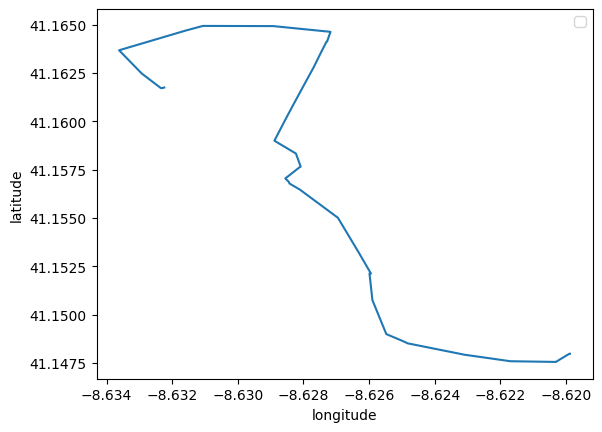

In [41]:
for i, path in enumerate(paths):
    if i == 1:
        a = np.array(path).T
        plt.plot(a[0],a[1])

plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.title('Sample Paths')
plt.legend()

plt.show()

In [43]:
data.iloc[208905]['POLYLINE']

'[[-8.619876,41.147973],[-8.619894,41.147973],[-8.620308,41.14755],[-8.621694,41.147586],[-8.622549,41.147793],[-8.622549,41.147793],[-8.62308,41.147919],[-8.624826,41.148513],[-8.624934,41.148603],[-8.625474,41.14899],[-8.625897,41.150745],[-8.625987,41.152131],[-8.625942,41.152122],[-8.626311,41.153202],[-8.62695,41.155011],[-8.628102,41.15646],[-8.628426,41.156784],[-8.628444,41.156865],[-8.628552,41.157045],[-8.62812,41.157621],[-8.628084,41.157657],[-8.628228,41.158332],[-8.628885,41.158998],[-8.628543,41.160114],[-8.628354,41.160717],[-8.627958,41.161959],[-8.627697,41.162769],[-8.627463,41.16357],[-8.627301,41.16411],[-8.627274,41.164137],[-8.627274,41.164155],[-8.627175,41.164632],[-8.628921,41.164929],[-8.631063,41.164938],[-8.631576,41.164704],[-8.631846,41.164569],[-8.633619,41.163678],[-8.632926,41.162472],[-8.632341,41.161716],[-8.632269,41.161734],[-8.632242,41.161752]]'

In [45]:
training.iloc[208905]

TRIP_ID         1376629824620000480
CALL_TYPE                         C
ORIGIN_CALL                     NaN
ORIGIN_STAND                    NaN
TAXI_ID                    20000480
DAY_TYPE                          A
MISSING_DATA                  False
YR                             2013
MON                               8
DAY                              15
HR                               22
WK                                3
TRIP_TIME                     915.0
Name: 208907, dtype: object

In [76]:
import pickle

In [273]:
with open('finalknnmodel.pkl','wb') as f:
    pickle.dump(knn,f)

with open('finalknnmodel.pkl', 'rb') as f:
    knn2 = pickle.load(f)

In [256]:
pred2 = knn2.predict(pktest.drop(columns = 'TRIP_TIME'))

In [257]:
np.sqrt(np.sum((pktest['TRIP_TIME']-pred2)**2)/pktest.shape[0])

534.5973896157343

In [267]:
A = knn2.predict(pktruetest)